In [5]:
!pip install fast-ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 4.9 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive")

Mounted at /content/drive


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression
from fast_ml.model_development import train_valid_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2 ,f_classif
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

In [8]:
loanData = pd.read_csv('DM1 Project/CleanedData/cleanLoanData.csv')
loanData = loanData.drop(columns = ['Unnamed: 0'])

In [ ]:
# loanData = pd.read_csv('cleanLoanData.csv')
# loanData = loanData.drop(columns = ['Unnamed: 0'])

#### Splitting into Train-Test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(loanData, target = 'MIS_Status',train_size=0.8, valid_size=0.1, test_size=0.1) 

In [12]:
#checking shapes of all splitted sets
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(206864, 19)
(206864,)
(25858, 19)
(25858,)
(25858, 19)
(25858,)


### Scaling the dataset for feature importance selections

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_val_scaled = scaler.transform(X_val)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)

#### Selecting scores of features

In [14]:
bestfeatures = SelectKBest(score_func = f_classif, k='all')
fit = bestfeatures.fit(X_train, y_train)
scores = pd.DataFrame(fit.scores_.round(6))
columns = pd.DataFrame(X_train.columns)
featureScores = pd.concat([columns, scores], axis = 1)
featureScores.columns = ['Feature','Score']
featureScores = featureScores.sort_values('Score', ascending = False, ignore_index=True)
featureScores

,Feature,Score
0,ChgOffPrinGr,59554.953816
1,Term,40164.851800
2,SBA_Gurantee_percent,9746.772034
3,IsDisbLargerThanGrAppv,4746.103293
4,DisbursementDuration_days,2829.373954
5,LowDoc,2745.210032
6,SBA_Appv,2121.641705
7,GrAppv,1458.928025
8,RevLineCr,1388.032786
9,DisbursementGross,926.652191


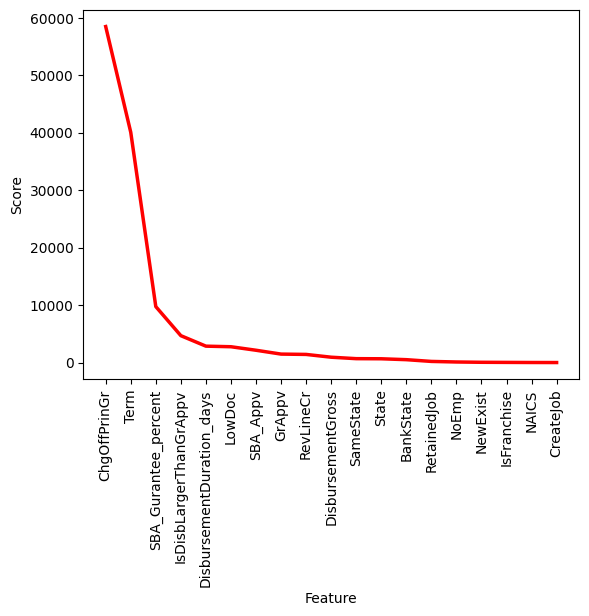

In [ ]:
sns.lineplot(data = featureScores, x = "Feature", y = "Score", color = "red", linewidth=2.5)
plt.xticks(rotation = 90)
plt.show()

In [15]:
#Dropping features
loan_data_fdrop = loanData.drop(['State','BankState','RetainedJob','NoEmp','NewExist','IsFranchise','NAICS','CreateJob'], axis = 1)

#Spliting into train-val-test
X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(loan_data_fdrop, target = 'MIS_Status',train_size=0.8, valid_size=0.1, test_size=0.1) 

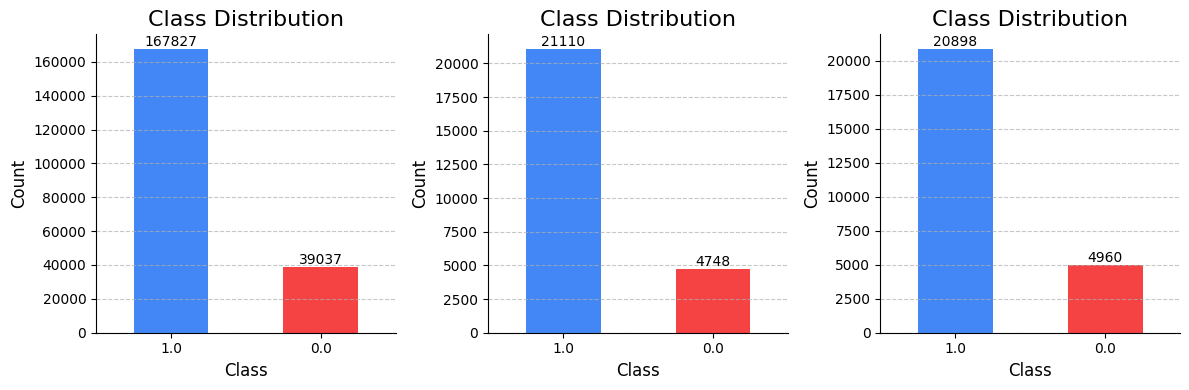

In [ ]:
import matplotlib.pyplot as plt

fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
colors = ['#4287f5', '#f54242']

for i, subplot in enumerate([ax, ax2, ax3]):
    y_values = [y_train, y_val, y_test][i]
    y_values.value_counts().plot(kind='bar', ax=subplot, color=colors)

    subplot.set_title('Class Distribution', fontsize=16)
    subplot.set_xlabel('Class', fontsize=12)
    subplot.set_ylabel('Count', fontsize=12)
    subplot.tick_params(axis='x', rotation=0, labelsize=10)
    subplot.tick_params(axis='y', labelsize=10)
    subplot.grid(axis='y', linestyle='--', alpha=0.7)

    for p in subplot.patches:
        subplot.annotate(format(p.get_height(), '.0f'),
                         (p.get_x() + p.get_width() / 2, p.get_height()),
                         ha='center', va='center', xytext=(0, 5),
                         textcoords='offset points', fontsize=10, color='black')

    subplot.spines['top'].set_visible(False)
    subplot.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### Grid Search for Random Forest

#### Random Forest

In [ ]:
# estimator = RandomForestClassifier(random_state = 0)

In [ ]:
# estimator.get_params()

In [ ]:
# Random Forest
pipe_rf  = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state = 0, class_weight = 'balanced'))])

In [ ]:
rf_params = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler()],
    'clf__n_estimators': [10, 50, 100, 200, 500],
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 2, 5, 10],
    'clf__min_samples_split': [2, 4, 8],
    'clf__min_samples_leaf': [1, 2, 5]
    }

cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 2, random_state = 0) #5 Fold cv repeated 2 times

The factor param controls the rate at which the resources grow and the rate at which the number of candidates decrease. Per iter :-> n_reources*factor and n_candidates/factor

In [ ]:
gs = HalvingGridSearchCV(pipe_rf, rf_params, scoring="f1_macro", n_jobs=-1, min_resources="exhaust", factor=3, verbose = 1, cv = cv)
gs.fit(X_train, y_train)
y_pred = gs.predict(X_val)

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 283
max_resources_: 206864
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1440
n_resources: 283
Fitting 10 folds for each of 1440 candidates, totalling 14400 fits
----------
iter: 1
n_candidates: 480
n_resources: 849
Fitting 10 folds for each of 480 candidates, totalling 4800 fits
----------
iter: 2
n_candidates: 160
n_resources: 2547
Fitting 10 folds for each of 160 candidates, totalling 1600 fits
----------
iter: 3
n_candidates: 54
n_resources: 7641
Fitting 10 folds for each of 54 candidates, totalling 540 fits
----------
iter: 4
n_candidates: 18
n_resources: 22923
Fitting 10 folds for each of 18 candidates, totalling 180 fits
----------
iter: 5
n_candidates: 6
n_resources: 68769
Fitting 10 folds for each of 6 candidates, totalling 60 fits
----------
iter: 6
n_candidates: 2
n_resources: 206307
Fitting 10 folds for each of 2 candidates, totalling 20 fits


:::Results:::

In [ ]:
print("accuracy",metrics.accuracy_score(y_val, y_pred))
print("f1 score macro",metrics.f1_score(y_val, y_pred, average='macro')) 
print("f1 score micro",metrics.f1_score(y_val, y_pred, average='micro')) 
print("precision score",metrics.precision_score(y_val, y_pred, average='macro')) 
print("recall score",metrics.recall_score(y_val, y_pred, average='macro')) 
print("hamming_loss",metrics.hamming_loss(y_val, y_pred))
print("classification_report", metrics.classification_report(y_val, y_pred))

In [ ]:
# Printing the number of resouces exhausted in each iteration
print("Number of resources used in each iteration: ", gs.n_resources_)

# Printing out the best parameters for the selected classifier
print('Best Parameters: ', gs.best_params_)

# Access the best set of parameters
best_params_rf = gs.best_params_

# Stores the optimum model in best_pipe
best_pipe_rf = gs.best_estimator_

results_df_rf = pd.DataFrame.from_dict(gs.cv_results_, orient='columns')

Training using the best parameters obtained by Grid Search

In [9]:
tuned_rf_pipe = Pipeline([('scaler',StandardScaler()),
                          ('clf', RandomForestClassifier(n_estimators = 200, criterion = 'gini', max_depth = 2,
                                                         min_samples_split = 2, min_samples_leaf = 2, random_state = 0))])

In [16]:
#Dropping features
X = loan_data_fdrop.drop(['MIS_Status'], axis = 1)
y = loan_data_fdrop['MIS_Status']

#Spliting into train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 0, shuffle = True)

In [17]:
tuned_rf_pipe.fit(X_train, y_train)
y_test_pred = tuned_rf_pipe.predict(X_test)

In [18]:
def plot_confusion_matrix(y_true, y_pred, labels = ['CHGOFF', 'PIF'],
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = metrics.confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

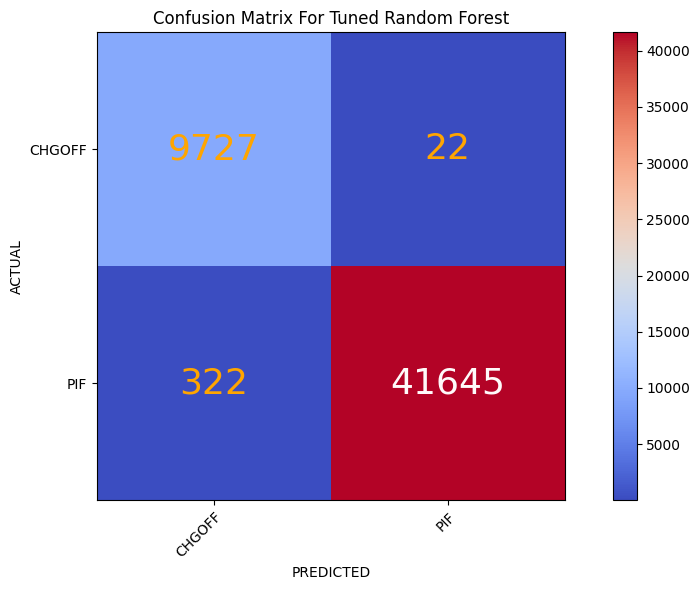

In [19]:
plot_confusion_matrix(y_test, y_test_pred, title="Confusion Matrix For Tuned Random Forest")
np.set_printoptions(precision=1)
# Plot non-normalized confusion matrix
plt.show()

In [20]:
# Final Classification Report
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      9749
         1.0       1.00      0.99      1.00     41967

    accuracy                           0.99     51716
   macro avg       0.98      1.00      0.99     51716
weighted avg       0.99      0.99      0.99     51716



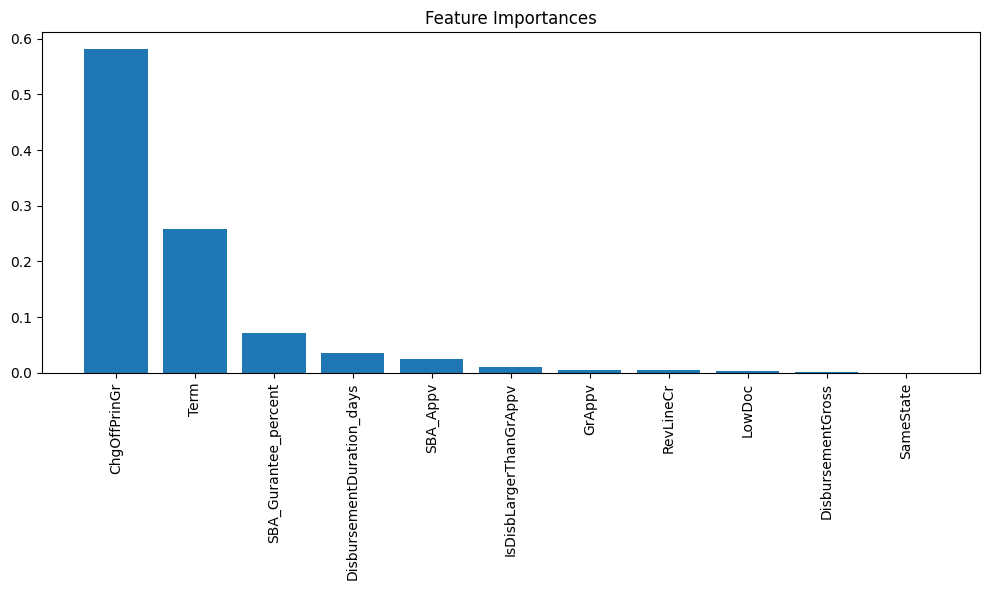

In [21]:
rf_model = tuned_rf_pipe.named_steps['clf']
importances = rf_model.feature_importances_
feature_names = X_train.columns

indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), sorted_importances, align="center")
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=90)
plt.tight_layout()
plt.show()

In [22]:
#Getting all the missclassified examples
mask = (y_test != y_test_pred)
missclassified_data = X_test[mask][['ChgOffPrinGr','Term','SBA_Gurantee_percent','DisbursementDuration_days']]
missclassified_data.head()

,ChgOffPrinGr,Term,SBA_Gurantee_percent,DisbursementDuration_days
185755,1127.0,30,0.5,42.0
38462,1427.0,49,0.5,168.0
166818,4002.0,4,0.5,45.0
103382,47608.0,155,0.9,97.0
30533,7814.0,31,0.5,61.0


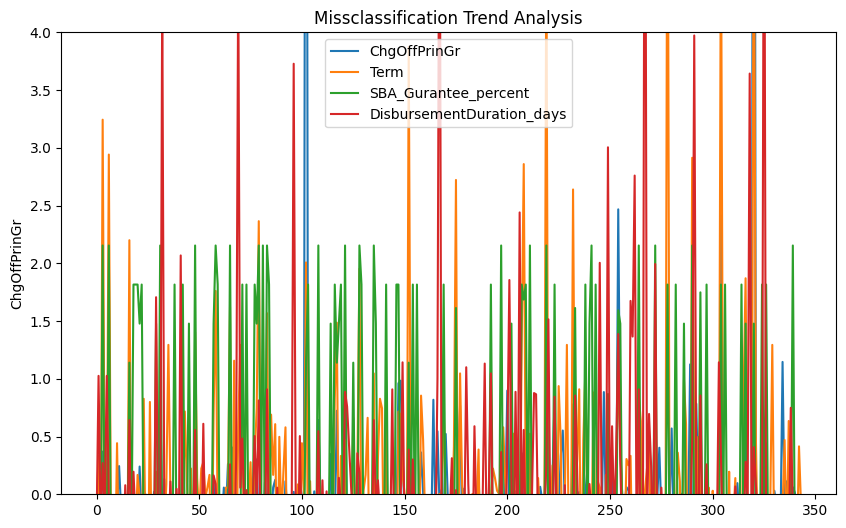

In [23]:
scaler = StandardScaler()
missclassified_data_scaled = scaler.fit_transform(missclassified_data)
missclassified_data = pd.DataFrame(missclassified_data_scaled, columns=missclassified_data.columns)

plt.figure(figsize = (10,6))

for col in missclassified_data.columns:
  sns.lineplot(data = missclassified_data[col], label = col)

plt.title('Missclassification Trend Analysis')
plt.ylim((0,4))
plt.legend()
plt.show()